In [1]:
import torch
from torch.utils.data import TensorDataset
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_state = 1103
H = 32
N = 1000
batch_size = int(N/10)
learning_rate = 0.05
momen = 0.0
epochs = 100
X, y = make_moons(noise=0.1,
                    n_samples=N,
                    random_state=random_state)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                    random_state=random_state)
X_train_t = torch.from_numpy(X_train).to(torch.float32).to(device)
y_train_t = torch.from_numpy(y_train).to(torch.long).to(device)
X_test_t = torch.from_numpy(X_test).to(torch.float32).to(device)
y_test_t = torch.from_numpy(y_test).to(torch.long).to(device)
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

## SVI (new fully autograd implementation)

In [2]:
import torch.nn as nn
import torch.nn.functional as F
# from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt
import copy

In [3]:
class two_moon_net_SVI(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(nn.Linear(2, H))
        self.convs.append(nn.Linear(H, 2))

        #### New lines for SVI ####
        # If any layer true, then it needs to use SVI
        self.layers_with_SVI = [True for i in range(len(self.convs))]
        # Append pre-activation \tilde{X}_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_Xtilde = []
        # Append the grad of L w.r.t. X_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_grad = []
        self.on_training = True
        #### End #####

    #### New lines for SVI ####
    # Avoid gradient accumulation
    def turn_on_off_grad(self, on = True):
        for param in self.parameters():
            param.requires_grad = on
    #### End #####

    def check_layer_grad(self):
        for name, param in self.named_parameters():
            if param.grad is not None:
                print(name, param.grad.norm())

    def check_init_norm(self):
        print("#### Initial norm of parameters: ")
        for name, param in self.named_parameters():
            print(name, param.norm())
        

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            #### New lines for SVI ####
            # This is added b/c o/w the gradient backprop w.r.t. new loss also gets to earlier layers (undesirable)
            if self.layers_with_SVI[i] and self.on_training:
                x_tmp = x.detach().clone().to(device)
                self.layers_Xtilde.append(conv(x_tmp))
            #### End #####
            x = conv(x)
            if i < len(self.convs) - 1:
                x = F.relu(x)
            else:
                x = F.softmax(x, dim=1)
            #### New lines for SVI ####
            if self.layers_with_SVI[i] and self.on_training:
                x.retain_grad()  # To get the gradient with respect to output
                self.layers_grad.append(x)
            #### End #####
        # return F.softmax(x, dim = 1)
        return x

In [4]:
cost = nn.MSELoss()

def test(model, x, y):
    model.eval()
    out = model(x)
    y = F.one_hot(y).to(torch.float)
    loss = cost(out, y) 
    return loss.item()

def train_SVI(model, x, y):
    model.train()
    # # Uncomment if want to debug
    # print(X.norm())
    # model.check_init_norm()
    #### New lines for SVI ####
    # NOTE: lines below are necessary, as o/w model.layers_x grow in size as epoches increases
    model.layers_Xtilde = []
    model.layers_grad = []
    model.on_training = True
    #### End #####
    out = model(x)
    y = F.one_hot(y).to(torch.float)
    loss = cost(out, y) # MSE was \|x\|^2_2
    #### New lines for SVI #### 
    model.turn_on_off_grad(on = False) 
    #### End #####
    loss.backward() # By this time, model parameters should have no gradients
    # # Uncomment if want to debug
    # print(f'#### Grad norm before SVI')
    # model.check_layer_grad()
    #### New lines for SVI ####
    loss_tilde = 0
    for Xlplus1, Xlplus1grad in zip(model.layers_Xtilde, model.layers_grad):
        Xlplus1grad = Xlplus1grad.grad.detach().to(device)
        # This is correct, I have verified it on SVI_old to give the same results
        loss_tilde += (Xlplus1*Xlplus1grad).sum()
    model.turn_on_off_grad(on = True)
    loss_tilde.backward()  # To get update direction by MVI for all layers at once
    # # Uncomment if want to debug
    # print(f'#### Grad norm after SVI')
    # model.check_layer_grad()
    # raise Exception("Stop here")
    model.on_training = False  # To avoid additional .retain_grad()
    #### End #####
    return loss.item()

In [5]:
# With SVI
train_loss_all, train_acc_all = np.zeros(epochs), np.zeros(epochs)
test_loss_all, test_acc_all = np.zeros(epochs), np.zeros(epochs)
layer_1_norm_all, layer_2_norm_all = np.zeros(epochs), np.zeros(epochs)
torch.manual_seed(random_state)
model = two_moon_net_SVI(H).to(device)
SVI_dict_ref = copy.deepcopy(model.state_dict())
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momen)
for t in range(epochs):
    ### Train
    size = len(train_dataloader.dataset)
    train_loss, train_correct = 0, 0
    for X, y in train_dataloader:
        optimizer.zero_grad()
        train_loss += train_SVI(model, X, y)
        pred = model(X).argmax(1)
        train_correct += (pred == y).type(torch.float).sum().item()
        optimizer.step()
    train_correct /= size
    train_loss /= size
    train_loss_all[t] = train_loss
    train_acc_all[t] = train_correct
    ### Attach difference in parameter updates
    for name, param in model.named_parameters():
        if '0' in name:
            layer_1_norm_all[t] += torch.norm(param - SVI_dict_ref[name])
        else:
            layer_2_norm_all[t] += torch.norm(param - SVI_dict_ref[name])
    ### Test
    size = len(test_dataloader.dataset)
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        model.eval()
        for X, y in test_dataloader:
            test_loss += test(model, X, y)
            pred = model(X).argmax(1)
            test_correct += (pred == y).type(torch.float).sum().item()
    test_correct /= size
    test_loss /= size
    test_loss_all[t] = test_loss
    test_acc_all[t] = test_correct
print(f'SVI new, H={H}, random_state={random_state}')
print('learning rate=', learning_rate, ', train accuracy=',
        train_acc_all[t] * 100, '%, test accuracy=', test_acc_all[t] * 100, '%')
print(f'training loss = {train_loss_all[t]:.4f}, test loss = {test_loss_all[t]:.4f}')


SVI_dict_final = copy.deepcopy(model.state_dict())
SVI_results = {'train_loss': train_loss_all, 
                'train_acc': train_acc_all, 
                'test_loss': test_loss_all, 
                'test_acc': test_acc_all,
                'layer_1_norm': layer_1_norm_all,
                'layer_2_norm': layer_2_norm_all}

SVI new, H=32, random_state=1103
learning rate= 0.05 , train accuracy= 91.8 %, test accuracy= 89.8 %
training loss = 0.0006, test loss = 0.0007


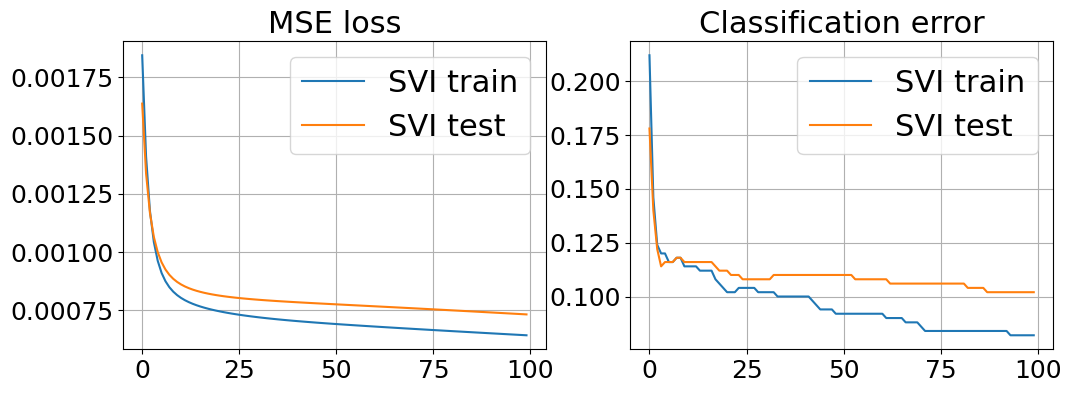

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fsize = 22
ax[0].plot(SVI_results['train_loss'], label='SVI train')
ax[0].plot(SVI_results['test_loss'], label='SVI test')
ax[0].set_title('MSE loss', fontsize=fsize)
ax[0].legend(fontsize=fsize)
ax[1].plot(1-SVI_results['train_acc'], label='SVI train')
ax[1].plot(1-SVI_results['test_acc'], label='SVI test')
ax[1].set_title('Classification error', fontsize=fsize)
ax[1].legend(fontsize=fsize)
ax[0].grid()
ax[1].grid()
ax[0].tick_params(labelsize=fsize-4)
ax[1].tick_params(labelsize=fsize-4)

## SVI (old autograd + manual implementation)

In [8]:
import pandas as pd
from torch.autograd import Variable
import time
import torch.nn.functional as F
import torch.nn as nn
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Below for change last layer, fully connected case


class CLF_NN_one_layer_relu(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.fc1 = nn.Linear(2, H)
        self.fc2 = nn.Linear(H, 2)

    def forward(self, x, retain_grad=True):
        self.layers_Xtilde = [self.fc1(x)]
        x = F.relu(self.fc1(x))  # 2->32
        if retain_grad:
            x.retain_grad()
        self.layer1_x = x
        self.layers_grad = [self.layer1_x]
        layer2_x = self.fc2(self.layer1_x)  # 32->2
        self.layers_Xtilde.append(layer2_x)
        layer2_x = F.softmax(layer2_x, dim=1)
        self.layers_grad.append(layer2_x)
        return layer2_x

    def check_layer_grad(self):
        for name, param in self.named_parameters():
            if param.grad is not None:
                print(name, param.grad.norm())

    def check_init_norm(self):
        print("#### Initial norm of parameters: ")
        for name, param in self.named_parameters():
            print(name, param.norm())


class CLF_NN_one_layer_relu_feature(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.fc1 = nn.Linear(2, H)
        self.fc2 = nn.Linear(H, H)

    def forward(self, x):
        # x = nn.ReLU(self.fc1(x))#2->32
        x = F.relu(self.fc1(x))  # 2->32
        x = self.fc2(x)  # 32->2
        return x


class CLF_NN_one_layer_relu_feature1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)

    def forward(self, x):
        x = self.fc1(x)
        return x


def train_loop(dataloader, model, loss_fn, optimizer, verbose, model_to_feature_ls=[], batch_size=1, data='moon'):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # # Uncomment if want to debug
        # print(X.norm())
        # model.check_init_norm()
        # ##
        pred = model(X).to(torch.float)
        Y = F.one_hot(y).to(torch.float)
        loss = 0.5*loss_fn(pred, Y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        loss /= batch_size # Important, as gradient is handed-coded
        # # Uncomment if want to debug
        # print(f'#### Grad norm before SVI')
        # model.check_layer_grad()
        if len(model_to_feature_ls) > 0:
            # 1. Collect all parameters in model and all layers
            Theta_dict = model.state_dict()
            all_layers = list(model.children())
            tot_layer = len(all_layers)
            for (curr_layer, child) in enumerate(model.children()):
                # 2. Get the nonlinear feature at each layer:
                model_to_feature_sub = model_to_feature_ls[curr_layer]
                if curr_layer > 0:
                    # Update previous weights only for 1st hidden layer onward
                    old_dict = model_to_feature_sub.state_dict()
                    for prev_layer in range(1, curr_layer+1):
                        old_dict[f'fc{prev_layer}.bias'] = Theta_dict[f'fc{prev_layer}.bias']
                        old_dict[f'fc{prev_layer}.weight'] = Theta_dict[f'fc{prev_layer}.weight']
                    model_to_feature_sub.load_state_dict(old_dict)
                feature = model_to_feature_sub(X).to(device)
                n = feature.shape[0]  # Numer of samples
                # For the bias
                feature = torch.cat((feature, torch.ones(n, 1).to(device)),
                                    1).to(device)  # n-by-(H+1)
                # 5. Compute gradient and update
                if curr_layer == tot_layer-1:
                    # if batch == 0:
                    #     print(f'Layer {curr_layer}')
                    output = model(X).to(device)
                    Y_new = F.one_hot(y.to(torch.int64)).to(device)
                    res = (output - Y_new).to(device)
                else:
                    # if batch == 0:
                    #     print(f'Layer {curr_layer}')
                    res = eval(
                        f'model.layer{curr_layer+1}_x.grad').to(device)
                grad = torch.transpose(torch.matmul(torch.transpose(
                    feature, 0, 1), res), 0, 1).clone().detach()/batch_size
                # print(grad.shape)
                # 6. Update gradient
                i = 0
                for param in child.parameters():
                    if i == 1:
                        param.grad = grad[:, -
                                          1].clone().detach().to(device)
                    else:
                        param.grad = grad[:, :-1].clone().detach().to(device)
                    i += 1
        # # Uncomment if want to debug
        # print(f'#### Grad norm after SVI')
        # model.check_layer_grad()
        # raise Exception("Stop here")
        optimizer.step()
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        if verbose and (batch % 50 == 0):
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    # print(f'Train correct {correct}')
    train_loss /= size
    correct /= size
    if verbose:
        print(
            f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    return train_loss, correct


def test_loop(dataloader, model, loss_fn, verbose):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X, retain_grad = False)
            Y = F.one_hot(y).to(torch.float)
            test_loss += 0.5*loss_fn(pred, Y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # print(f'Test correct {correct}')
    test_loss /= size*batch_size
    correct /= size
    if verbose:
        print(
            f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [9]:
# NOTE; it depends on learning rate indeed

verbose = 0
loss_fn = nn.MSELoss(reduction = 'sum')
# In the latter case, it is p, the dimension of input feature, not hidden neuron number
# VI
start = time.time()
train_loss_all, train_acc_all = np.zeros(epochs), np.zeros(epochs)
test_loss_all, test_acc_all = np.zeros(epochs), np.zeros(epochs)
layer_1_norm_all, layer_2_norm_all = np.zeros(epochs), np.zeros(epochs)
torch.manual_seed(random_state)
model_VI = CLF_NN_one_layer_relu(H).to(device)
SVI_dict_ref_old = copy.deepcopy(model_VI.state_dict())
mod_feature = CLF_NN_one_layer_relu_feature(H).to(device)
old_dict = mod_feature.state_dict()
old_dict['fc2.bias'] = torch.zeros(H)
old_dict['fc2.weight'] = torch.diag(torch.ones(H))
mod_feature.load_state_dict(old_dict)
mod_feature1 = CLF_NN_one_layer_relu_feature1().to(device)
old_dict = mod_feature1.state_dict()
old_dict['fc1.bias'] = torch.zeros(2)
old_dict['fc1.weight'] = torch.diag(torch.ones(2))
mod_feature1.load_state_dict(old_dict)
model_to_feature_ls = [mod_feature1, mod_feature]
optimizer = torch.optim.SGD(
    model_VI.parameters(), lr=learning_rate, momentum=momen)
for t in range(epochs):
    if verbose:
        print(f"Epoch {t+1}\n-------------------------------")
    train_loss_all[t], train_acc_all[t] = train_loop(
        train_dataloader, model_VI, loss_fn, optimizer, verbose, 
        model_to_feature_ls=model_to_feature_ls, 
        batch_size=batch_size)
    test_loss_all[t], test_acc_all[t] = test_loop(
        test_dataloader, model_VI, loss_fn, verbose)
    ### Attach difference in parameter updates
    for name, param in model_VI.named_parameters():
        if '1' in name:
            layer_1_norm_all[t] += torch.norm(param - SVI_dict_ref_old[name])
        else:
            layer_2_norm_all[t] += torch.norm(param - SVI_dict_ref_old[name])
    ### Test
end = time.time()
print(f'SVI old, H={H}, random_state={random_state}')
print('learning rate=', learning_rate, ', train accuracy=',
        train_acc_all[t] * 100, '%, test accuracy=', test_acc_all[t] * 100, '%')
print(f'training loss = {train_loss_all[t]:.4f}, test loss = {test_loss_all[t]:.4f}')

SVI_dict_final_old = copy.deepcopy(model_VI.state_dict())
SVI_results_old = {'train_loss': train_loss_all, 
                'train_acc': train_acc_all, 
                'test_loss': test_loss_all, 
                'test_acc': test_acc_all,
                'layer_1_norm': layer_1_norm_all,
                'layer_2_norm': layer_2_norm_all}

/usr/local/lib/python3.9/dist-packages/torch/autograd/__init__.py:197: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [2, 32], strides() = [1, 2]
param.sizes() = [2, 32], strides() = [32, 1] (Triggered internally at ../torch/csrc/autograd/functions/accumulate_grad.h:202.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


SVI old, H=32, random_state=1103
learning rate= 0.05 , train accuracy= 91.8 %, test accuracy= 89.8 %
training loss = 0.0006, test loss = 0.0007


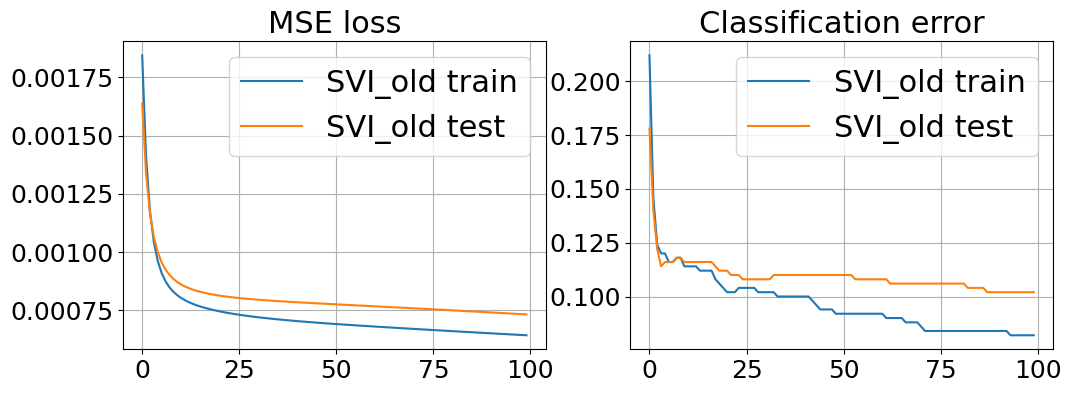

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fsize = 22
ax[0].plot(SVI_results_old['train_loss'], label='SVI_old train')
ax[0].plot(SVI_results_old['test_loss'], label='SVI_old test')
ax[0].set_title('MSE loss', fontsize=fsize)
ax[0].legend(fontsize=fsize)
ax[1].plot(1-SVI_results_old['train_acc'], label='SVI_old train')
ax[1].plot(1-SVI_results_old['test_acc'], label='SVI_old test')
ax[1].set_title('Classification error', fontsize=fsize)
ax[1].legend(fontsize=fsize)
ax[0].grid()
ax[1].grid()
ax[0].tick_params(labelsize=fsize-4)
ax[1].tick_params(labelsize=fsize-4)

## Step-by-step debug

In [10]:
for _ in [1]:
    continue
    for x, y in train_dataloader:
        break
    ### New SVI implementation
    torch.manual_seed(random_state)
    model = two_moon_net_SVI(H).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momen)
    model.train()
    # Uncomment if want to debug
    print(x.norm())
    model.check_init_norm()
    #### New lines for SVI ####
    # NOTE: lines below are necessary, as o/w model.layers_x grow in size as epoches increases
    model.layers_Xtilde = []
    model.layers_grad = []
    model.on_training = True
    #### End #####
    out = model(x)
    #### New lines for SVI ####
    cost = nn.MSELoss()
    #### End #####
    Y = F.one_hot(y).to(torch.float)
    loss = cost(out, Y) # The scale! MSE did not have 0.5 in front, which is not right
    #### New lines for SVI #### 
    model.turn_on_off_grad(on = False) 
    #### End #####
    loss.backward()
    print(f'#### Grad norm before SVI')
    model.check_layer_grad()
    #### New lines for SVI ####
    loss_tilde = 0
    for Xlplus1, Xlplus1grad in zip(model.layers_Xtilde, model.layers_grad):
        Xlplus1grad = Xlplus1grad.grad.detach().to(device)
        # This is correct, I have verified it on SVI_old to give the same results
        loss_tilde += (Xlplus1*Xlplus1grad).sum()
    model.turn_on_off_grad(on = True)
    loss_tilde.backward()  # To get update direction by MVI for all layers at once
    # Uncomment if want to debug
    print(f'#### Grad norm after SVI')
    model.check_layer_grad()

In [11]:
for _ in [1]:
    continue
    ### Old SVI implementation
    torch.manual_seed(random_state)
    model_VI = CLF_NN_one_layer_relu(H).to(device)
    SVI_dict_ref_old = copy.deepcopy(model_VI.state_dict())
    mod_feature = CLF_NN_one_layer_relu_feature(H).to(device)
    old_dict = mod_feature.state_dict()
    old_dict['fc2.bias'] = torch.zeros(H)
    old_dict['fc2.weight'] = torch.diag(torch.ones(H))
    mod_feature.load_state_dict(old_dict)
    mod_feature1 = CLF_NN_one_layer_relu_feature1().to(device)
    old_dict = mod_feature1.state_dict()
    old_dict['fc1.bias'] = torch.zeros(2)
    old_dict['fc1.weight'] = torch.diag(torch.ones(2))
    mod_feature1.load_state_dict(old_dict)
    model_to_feature_ls = [mod_feature1, mod_feature]
    print(x.norm())
    model_VI.check_init_norm()
    pred = model_VI(x).to(torch.float)
    Y = F.one_hot(y).to(torch.float)
    loss_fn = nn.MSELoss(reduction = 'sum')
    loss = 0.5*loss_fn(pred, Y)
    # Backpropagation
    loss.backward()
    print(f'#### Grad norm before SVI')
    model_VI.check_layer_grad()
    if len(model_to_feature_ls) > 0:
        # 1. Collect all parameters in model and all layers
        Theta_dict = model_VI.state_dict()
        all_layers = list(model_VI.children())
        tot_layer = len(all_layers)
        res_ls = []
        feature_ls = []
        for (curr_layer, child) in enumerate(model_VI.children()):
            # 2. Get the nonlinear feature at each layer:
            model_to_feature_sub = model_to_feature_ls[curr_layer]
            if curr_layer > 0:
                # Update previous weights only for 1st hidden layer onward
                old_dict = model_to_feature_sub.state_dict()
                for prev_layer in range(1, curr_layer+1):
                    old_dict[f'fc{prev_layer}.bias'] = Theta_dict[f'fc{prev_layer}.bias']
                    old_dict[f'fc{prev_layer}.weight'] = Theta_dict[f'fc{prev_layer}.weight']
                model_to_feature_sub.load_state_dict(old_dict)
            feature = model_to_feature_sub(x).to(device)
            n = feature.shape[0]  # Numer of samples
            # For the bias
            feature = torch.cat((feature, torch.ones(n, 1).to(device)),
                                1).to(device)  # n-by-(H+1)
            feature_ls.append(feature)
            # 5. Compute gradient and update
            if curr_layer == tot_layer-1:
                # if batch == 0:
                #     print(f'Layer {curr_layer}')
                output = model_VI(x).to(device)
                Y_new = F.one_hot(y.to(torch.int64)).to(device)
                res = (output - Y_new).to(device)
            else:
                # if batch == 0:
                #     print(f'Layer {curr_layer}')
                res = eval(
                    f'model_VI.layer{curr_layer+1}_x.grad').to(device)
            res_ls.append(res)
            grad = torch.transpose(torch.matmul(torch.transpose(
                feature, 0, 1), res), 0, 1).clone().detach()/batch_size
            # print(grad.shape)
            # 6. Update gradient
            i = 0
            for param in child.parameters():
                if i == 1:
                    param.grad = grad[:, -
                                        1].clone().detach().to(device)
                else:
                    param.grad = grad[:, :-1].clone().detach().to(device)
                i += 1
    # Uncomment if want to debug
    print(f'#### Grad norm after SVI')
    model_VI.check_layer_grad()


## Compare results together

H = 32
SVI_old trainig loss:  0.000643, test loss: 0.000733
SVI trainig loss:  0.000643, test loss: 0.000733
SVI_old trainig accuracy: 91.8%, test accuracy: 89.8%
SVI trainig accuracy: 91.8%, test accuracy: 89.8%


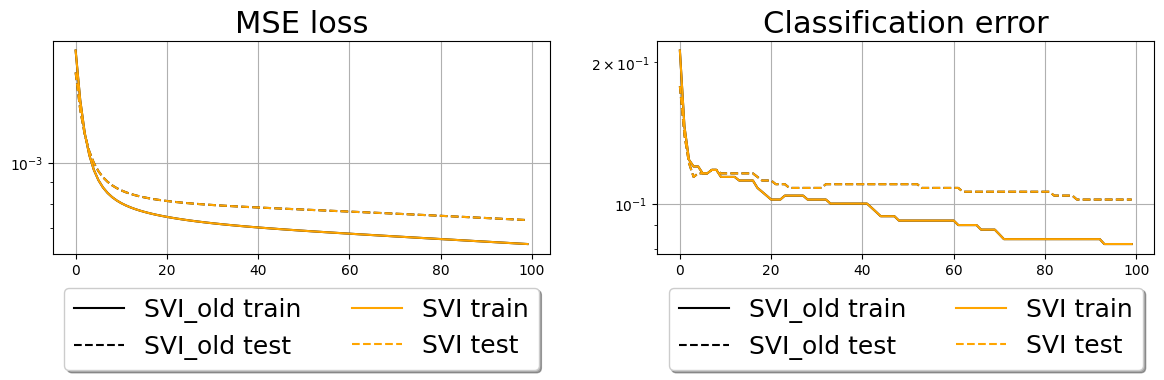

In [11]:
print(f'H = {H}')
print(f'SVI_old trainig loss: {SVI_results_old["train_loss"][-1]: .6f}, test loss: {SVI_results_old["test_loss"][-1]:.6f}')
print(f'SVI trainig loss: {SVI_results["train_loss"][-1]: .6f}, test loss: {SVI_results["test_loss"][-1]:.6f}')
print(f'SVI_old trainig accuracy: {100*SVI_results_old["train_acc"][-1]:.1f}%, test accuracy: {100*SVI_results_old["test_acc"][-1]:.1f}%')
print(f'SVI trainig accuracy: {100*SVI_results["train_acc"][-1]:.1f}%, test accuracy: {100*SVI_results["test_acc"][-1]:.1f}%')


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fsize = 22
ax[0].plot(SVI_results_old['train_loss'], label='SVI_old train', color = 'black')
ax[0].plot(SVI_results_old['test_loss'], label='SVI_old test', color = 'black', linestyle = '--')
ax[0].plot(SVI_results['train_loss'], label='SVI train', color = 'orange')
ax[0].plot(SVI_results['test_loss'], label='SVI test', color = 'orange', linestyle = '--')
ax[0].set_title('MSE loss', fontsize=fsize)
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            fancybox=True, shadow=True, ncol=2, fontsize=fsize-4)
ax[1].plot(1-SVI_results_old['train_acc'], label='SVI_old train', color = 'black')
ax[1].plot(1-SVI_results_old['test_acc'], label='SVI_old test', color = 'black', linestyle = '--')
ax[1].plot(1-SVI_results['train_acc'], label='SVI train', color = 'orange')
ax[1].plot(1-SVI_results['test_acc'], label='SVI test', color = 'orange', linestyle = '--')
ax[1].set_title('Classification error', fontsize=fsize)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
            fancybox=True, shadow=True, ncol=2, fontsize=fsize-4)
ax[0].grid()
ax[1].grid()
# ax[0].tick_params(labelsize=fsize-4)
# ax[1].tick_params(labelsize=fsize-4)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
fig.tight_layout()
plt.show()

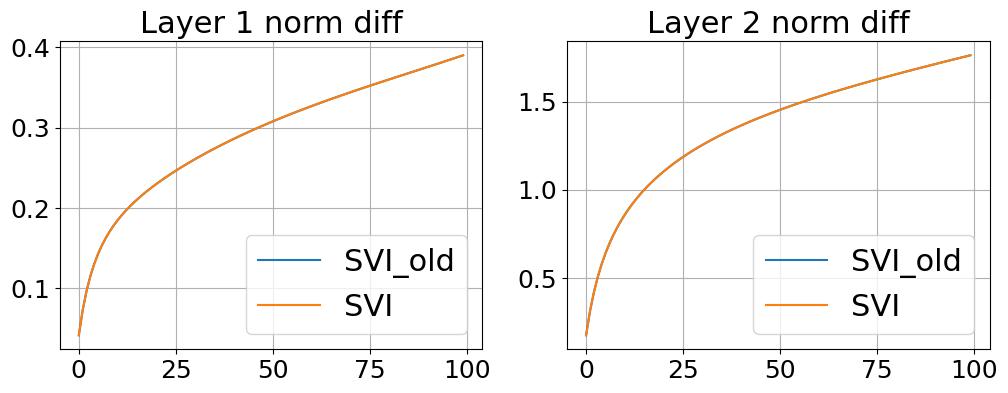

In [12]:
# Plot changes in parameter norms
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fsize = 22
ax[0].plot(SVI_results_old['layer_1_norm'], label='SVI_old')
ax[0].plot(SVI_results['layer_1_norm'], label='SVI')
ax[0].set_title('Layer 1 norm diff', fontsize=fsize)
ax[0].legend(fontsize=fsize)
ax[1].plot(SVI_results_old['layer_2_norm'], label='SVI_old')
ax[1].plot(SVI_results['layer_2_norm'], label='SVI')
ax[1].set_title('Layer 2 norm diff', fontsize=fsize)
ax[1].legend(fontsize=fsize)
ax[0].grid()
ax[1].grid()
ax[0].tick_params(labelsize=fsize-4)
ax[1].tick_params(labelsize=fsize-4)

In [13]:
def plot_dynamics_against_X1(a_SGD, w_SGD, a_VI, w_VI):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    for i in range(2):
        if i == 0:
            a = a_SGD
            w = w_SGD
        else:
            a = a_VI
            w = w_VI
        ax[i].set_xlabel(r"$X_1$", fontsize=16)
        ax[i].set_ylabel(r"$X_2$", fontsize=16)
        # for j in range(len(a[0])):
        #     ax[i].plot(a[0][j], a[1][j], color='black')
        ax[i].scatter(a[0][:, 0], a[0][:, 1], color='grey', label="Epoch = 0")
        for j in range(len(a[0])):
            ax[i].annotate('', xy=(a[1][j,0], a[1][j,1]), xytext=(a[0][j,0], a[0][j,1]),
                arrowprops=dict(facecolor='red', width=2, headwidth=8))
        ax[i].scatter(a[1][:, 0], a[1][:, 1], color='red', label=f"Epoch = {epochs}")
        if i == 0:
            ax[i].legend(ncol=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.4))
        if i == 1:
            ax[i].get_shared_x_axes().join(ax[0], ax[i])
            ax[i].get_shared_y_axes().join(ax[0], ax[i])
        plt.tight_layout()
    print(f'Top SVI_old, Bottom SVI')
    plt.show()


Check movement at layer 0


/tmp/ipykernel_147/1509794682.py:22: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[i].get_shared_x_axes().join(ax[0], ax[i])
/tmp/ipykernel_147/1509794682.py:23: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[i].get_shared_y_axes().join(ax[0], ax[i])


Top SVI_old, Bottom SVI


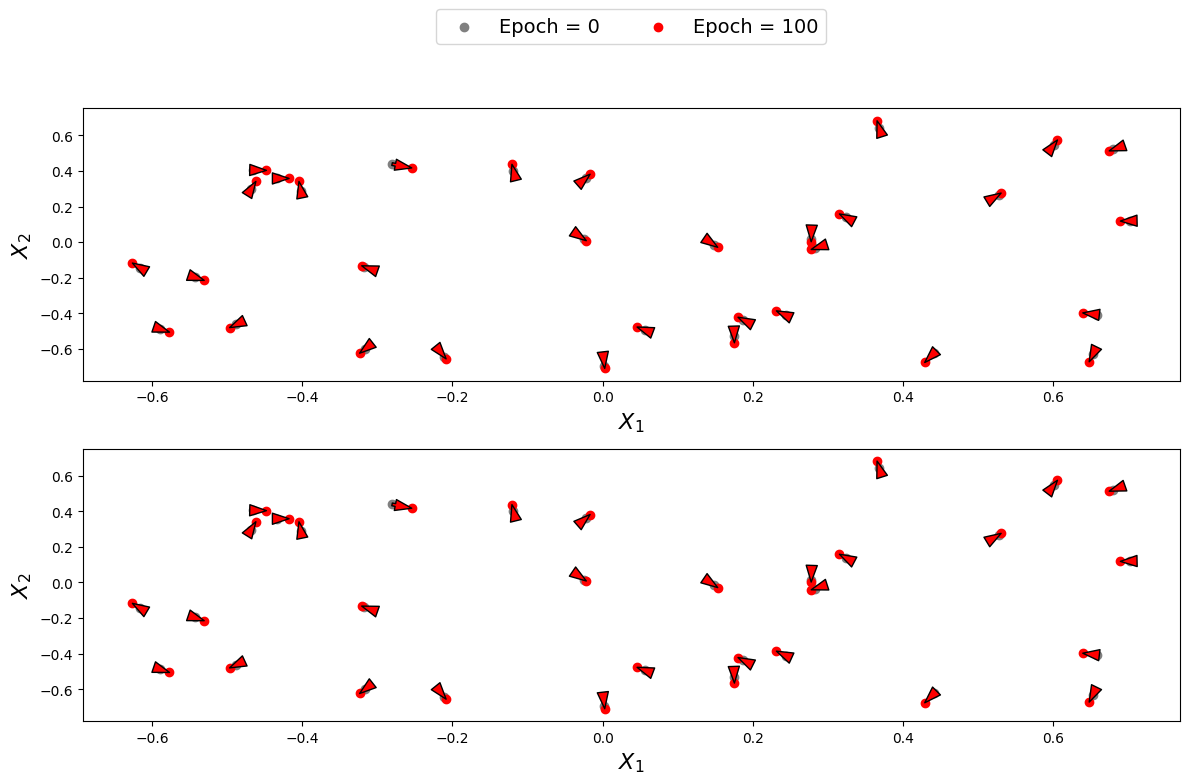

In [14]:
layer = 0 
key0 = f'fc{layer+1}.weight'
key = f'convs.{layer}.weight'
print(f'Check movement at layer {layer}')
w_ref_SVI_old = SVI_dict_ref_old[key0].cpu().detach().numpy()
w_VI_old = SVI_dict_final_old[key0].cpu().detach().numpy()
if layer == 1:
    w_ref_SVI_old = w_ref_SVI_old.T
    w_VI_old = w_VI_old.T
w_VI_final_old = np.sum(w_ref_SVI_old*w_VI_old, axis=1)

w_ref_SVI = SVI_dict_ref[key].cpu().detach().numpy()
w_VI = SVI_dict_final[key].cpu().detach().numpy()
if layer == 1:
    w_ref_SVI = w_ref_SVI.T
    w_VI = w_VI.T
w_VI_final = np.sum(w_ref_SVI*w_VI, axis=1)

a_VI_old = [w_ref_SVI_old, w_VI_old]
a_VI = [w_ref_SVI, w_VI]


plot_dynamics_against_X1(a_VI_old, w_VI_old, a_VI, w_VI)

Check movement at layer 1


/var/folders/5t/05bhmqvd19xdqc3hdxwdqh680000gn/T/ipykernel_53725/1509794682.py:22: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[i].get_shared_x_axes().join(ax[0], ax[i])
/var/folders/5t/05bhmqvd19xdqc3hdxwdqh680000gn/T/ipykernel_53725/1509794682.py:23: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[i].get_shared_y_axes().join(ax[0], ax[i])


Top SVI_old, Bottom SVI


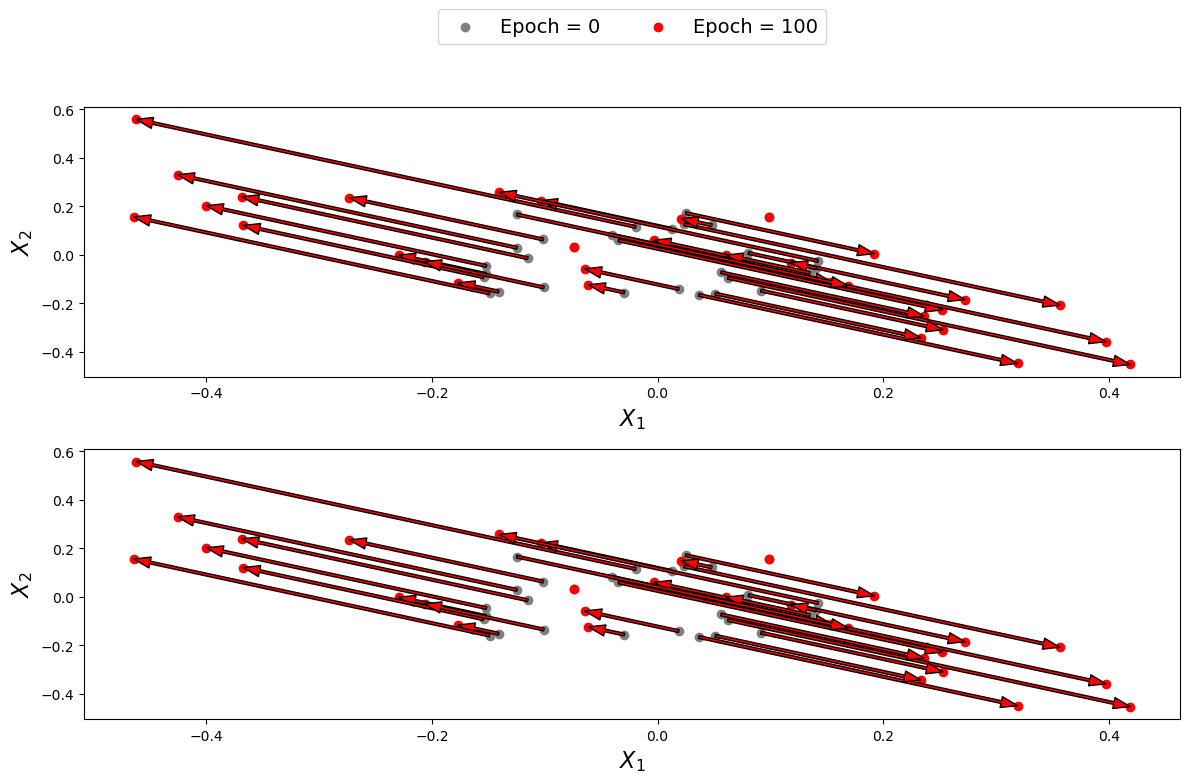

In [16]:
layer = 1 
key0 = f'fc{layer+1}.weight'
key = f'convs.{layer}.weight'
print(f'Check movement at layer {layer}')
w_ref_SVI_old = SVI_dict_ref_old[key0].cpu().detach().numpy()
w_VI_old = SVI_dict_final_old[key0].cpu().detach().numpy()
if layer == 1:
    w_ref_SVI_old = w_ref_SVI_old.T
    w_VI_old = w_VI_old.T
w_VI_final_old = np.sum(w_ref_SVI_old*w_VI_old, axis=1)

w_ref_SVI = SVI_dict_ref[key].cpu().detach().numpy()
w_VI = SVI_dict_final[key].cpu().detach().numpy()
if layer == 1:
    w_ref_SVI = w_ref_SVI.T
    w_VI = w_VI.T
w_VI_final = np.sum(w_ref_SVI*w_VI, axis=1)

a_VI_old = [w_ref_SVI_old, w_VI_old]
a_VI = [w_ref_SVI, w_VI]


plot_dynamics_against_X1(a_VI_old, w_VI_old, a_VI, w_VI)